## Lab 9: Convolutional Neural Networks

#### CSC 215 Artificial Intelligence (Spring 2019)

#### Dr. Haiquan Chen, California State University, Sacramento

# Helpful Functions for Tensorflow (Little Gems)

The following functions will be used with TensorFlow to help preprocess the data.  They allow you to build the feature vector for a neural network. 

* Predictors/Inputs 
    * Fill any missing inputs with the median for that column.  Use **missing_median**.
    * Encode textual/categorical values with **encode_text_dummy**.
    * Encode numeric values with **encode_numeric_zscore**.
* Output
    * Discard rows with missing outputs.
    * Encode textual/categorical values with **encode_text_index**.
    * Do not encode output numeric values.
* Produce final feature vectors (x) and expected output (y) with **to_xy**.

In [1]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low



# Computer Vision Data Sets

There are many data sets for computer vision.  Two of the most popular are the MNIST digits data set and the CIFAR image data sets.

## MNIST Digits Data Set

The [MNIST Digits Data Set](http://yann.lecun.com/exdb/mnist/) is very popular in the neural network research community.  A sample of it can be seen here:

![MNIST Data Set](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_mnist.png "MNIST Data Set")



## CIFAR Data Set

The [CIFAR-10 and CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) datasets are also frequently used by the neural network research community.

![cifar-10](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_8_cifar.png "cifar-10")

The CIFAR-10 data set contains images that are divided into 10 classes.  The CIFAR-100 data set contains 100 classes in a hierarchy. 



# Convolutional Neural Networks (CNNs)

The convolutional neural network (CNN) is a neural network technology that has profoundly impacted the area of computer vision (CV). In CNN, we use the following layer types:

* **Dense Layers** - Fully connected layers.  
* **Convolution Layers** - Used to scan across images. 
* **Max Pooling Layers** - Used to downsample images. 
* **Dropout Layer** - Prevent overfitting 
* **Flatten Layer** - Transform data of any shape into one dimensional  

## Convolution Layers

For the convolutional layer, We must specify the following hyper-parameters :

* Number of filters
* Filter Size
* Stride
* Padding
* Activation Function/Non-Linearity


A filter is a square-shaped object that scans over the image. The more filters that we give to a convolutional layer, the more features it can detect.


## Max Pooling Layers

Max-pool layers downsample the data.  This technique can avoid overfitting.

*** Typically, you can always place a max-pool layer immediately following convolutional layer.***



# Example of Training CNNs with Tensorflow

The following sections describe how to use TensorFlow/Keras with CNNs.

# Access to Data Sets

Keras provides built in access classes for MNIST which is already separated into two sets:

* **train** - Neural network will be trained with this.
* **test** - Used for validation.

In [3]:
import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Shape of x_train: {}".format(x_train.shape))
print("Shape of y_train: {}".format(y_train.shape))
print()
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_test: {}".format(y_test.shape))

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000,)

Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000,)


In [4]:
print("y_train: {}".format(y_train))

y_train: [5 0 4 ... 5 6 8]


# Display the Digits 

The following code shows what the MNIST files contain.

In [5]:
# Single MNIST digit
first = x_train[0]

pd.DataFrame(first)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,175,26,166,255,247,127,0,0,0,0
6,0,0,0,0,0,0,0,0,30,36,...,225,172,253,242,195,64,0,0,0,0
7,0,0,0,0,0,0,0,49,238,253,...,93,82,82,56,39,0,0,0,0,0
8,0,0,0,0,0,0,0,18,219,253,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,80,156,...,0,0,0,0,0,0,0,0,0,0


Image (#0): Which is digit '5'


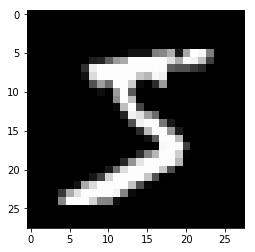

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

sample = 0    #  change this number to select another sample
digit = x_train[sample]
#print(type(digit))
#print(digit.shape)


plt.imshow(digit, cmap='gray')
print("Image (#{}): Which is digit '{}'".format(sample,y_train[sample]))

# Define CNN

In [7]:
# Load modules

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [8]:
# Define batch_size and # of epochs
batch_size = 128

In [9]:
# define input image dimensions
img_rows, img_cols = 28, 28

### Let's create x (images) first.        

### x must be 4D array

#### You must explicitly declare the depth of the input image. For example, a full-color image with all 3 RGB channels will have a depth of 3. 

In other words, we need to transform our dataset from the shape (n, rows, cols) to (n, rows, cols, depth).

#### Our MNIST images only have a depth of 1, but we must explicitly declare that.

In [10]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

In [11]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [12]:
x_train.dtype

dtype('uint8')

In [13]:
# convert to float32 for normalization
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [14]:
# normalize the data values to the range [0, 1]
x_train /= 255
x_test /= 255

In [15]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
Training samples: 60000
Test samples: 10000


### Now we have x ready. Let's create y (class labels)

In [16]:
print(y_train.shape)
print(y_train[:10])

(60000,)
[5 0 4 1 9 2 1 3 1 4]


### For classification, TensorFlow requires y in one hot-encoded format. 

In [17]:
num_classes = 10

# Converts a class vector (integers) to binary class matrix.   One-hot encoding!  Use with categorical_crossentropy.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [18]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
pd.DataFrame(y_test)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

### We are ready to define the CNN architecture now!

Let's start by declaring a sequential model format:

In [20]:
model = Sequential()

Next, we add the input layer.

The Conv2D layer creates a convolution kernel that is convolved with the layer input to produce outputs. Provide the following:

*  The number of convolution filters (neurons) to use

* kernel_size specifies the height and width of the 2D convolution window

* strides: An tuple of 2 integers, specifying the strides of the convolution along the height and width

* padding: one of "valid" or "same".  ***valid***: no padding. ***same***: zero padding.


* ***input_shape: should be the shape of 1 sample.*** In this case, it should (28, 28, 1) that corresponds to  the (rows, cols, depth) of each digit image.  When using Conv2D layer as the first layer in a model, you must provide input_shape, e.g. input_shape=(128, 128, 3) for 128x128 RGB pictures.

In [21]:
input_shape = (img_rows, img_cols, 1)

model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='valid',
                 activation='relu',
                 input_shape=input_shape))    #  in this case, input_shape = (img_rows, img_cols, 1)

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________


## Reflection:  


### Why the output shape is (None, 26, 26, 32) ?

The first dimension in a keras model is always the batch size.

### Why the depth is 32?


Note that number of filters from previous layer become the number of channels for current layer's input image.


### How 320 was calculated?

***total_params = filter_height $*$ filter_width $*$ input_image_channels $*$ number_of_filters + number_of_filters***

Next, we can simply add more layers to our model

In [23]:
# Note that number of filters from previous layer become the number of channels for current layer's input image.

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=None))
model.add(Dropout(0.25)) 

#### MaxPooling2D is a way to reduce the number of parameters in our model.   
Here we slide a 2x2 pooling filter across the previous layer and taking the max of the 4 values in the 2x2 filter.  

strides: Integer, or None. Factor by which to downscale. E.g. 2 will halve the input. If None, it will default to pool_size.

#### Dropout layer is a method for regularizing our model in order to prevent overfitting

So far, for model parameters, we've added two Convolution layers. To complete our model architecture, let's add a fully connected layer and then the output layer:

In [24]:
model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

For Dense layers, the first parameter is the output size of the layer. 

Note that the final layer has an output size of 10, corresponding to the 10 classes of digits.

Why use flatten layer here?

#### Also note that  Convolution layers must be flattened (made 1-dimensional) before passing them to the fully connected Dense layer.

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### How 18496 was calcuated?


Note that number of filters from previous layer become the number of channels for current layer's input image.

### Now all we need to do is to compile the model by defining the loss function and the optimizer, and then we'll be ready to train it.

#### Here for each epoch, we show not only "log loss" but also "accuracy" by using metrics=['accuracy']

In [26]:
from keras.optimizers import Adam

# show not only log loss but also accuracy for each epoch using metrics=['accuracy']

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(lr=0.001, decay=1e-6), metrics=['accuracy'])


In [27]:
x_train.shape

(60000, 28, 28, 1)

## Training/Fitting CNN

To fit the model, declare the batch size and number of epochs to train for, then pass in our training data.

This can take a while.  You can also use a variety of callbacks to set early-stopping rules.

Check this while you are waiting ...

http://scs.ryerson.ca/~aharley/vis/conv/


In [28]:
import time

start_time = time.time()

# 5% of dataset

model.fit(x_train[0:3000], y_train[0:3000],     
          batch_size=batch_size,
          epochs=2,
          verbose=2,
          validation_data=(x_test[0:500], y_test[0:500]))

elapsed_time = time.time() - start_time
print("Elapsed time: {}".format(hms_string(elapsed_time)))

Train on 3000 samples, validate on 500 samples
Epoch 1/3
 - 84s - loss: 1.2077 - acc: 0.6170 - val_loss: 0.4653 - val_acc: 0.8680
Epoch 2/3
 - 76s - loss: 0.4842 - acc: 0.8567 - val_loss: 0.2715 - val_acc: 0.9340
Epoch 3/3
 - 78s - loss: 0.3225 - acc: 0.9087 - val_loss: 0.1840 - val_acc: 0.9520
Elapsed time: 0:03:57.57


## Evaluate Accuracy in Keras


In [29]:
# evaluate() computes the loss and accuracy
score = model.evaluate(x_test[0:500], y_test[0:500], verbose=0)
score

[0.18404791021347047, 0.952]

In [31]:
print('Test loss: {}'.format(score[0]))
print('Test accuracy: {}'.format(score[1]))

Test loss: 0.18404791021347047
Test accuracy: 0.952


## Evaluate Other Metrics using Sklearn

In [32]:
from sklearn import metrics

y_true = np.argmax(y_test[0:500],axis=1)
pred = model.predict(x_test[0:500])
pred = np.argmax(pred,axis=1)

score = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(score))


f1 = metrics.f1_score(y_true, pred, average='weighted')
print('Averaged F1: {}'.format(f1))

           
print(metrics.classification_report(y_true, pred))

Accuracy: 0.952
Averaged F1: 0.9521197696416225
             precision    recall  f1-score   support

          0       0.93      1.00      0.97        42
          1       1.00      1.00      1.00        67
          2       0.98      0.89      0.93        55
          3       0.98      0.96      0.97        45
          4       0.98      0.96      0.97        55
          5       0.96      0.96      0.96        50
          6       0.97      0.91      0.94        43
          7       0.86      0.98      0.91        49
          8       0.95      0.90      0.92        40
          9       0.91      0.94      0.93        54

avg / total       0.95      0.95      0.95       500



### How to choose network archectures (# of layers, type of each layer, etc..)? 

When you're just starting out, you should replicate proven architectures from academic papers or use existing examples. Here's a link to many example implementations in Keras.

https://github.com/keras-team/keras/tree/master/examples

![cnn-exa](http://adventuresinmachinelearning.com/wp-content/uploads/2017/04/CNN-example-block-diagram.jpg "cnn-exa")

In [33]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

## CNN can handle ANY data types other than images!  The key is how you would view each sample as an image.

In [34]:
# x - inputs, 10000 samples of 128-dimensional vectors
# y - labels, 10000 samples of scalars from the set {0, 1, 2}

x = np.random.rand(10000, 128).astype("float32")
y = np.random.randint(3, size=(10000,1))


x

array([[0.6799392 , 0.36191964, 0.9124583 , ..., 0.7799125 , 0.22563718,
        0.8017766 ],
       [0.5623721 , 0.73669684, 0.1430908 , ..., 0.02221133, 0.00731862,
        0.68356097],
       [0.24273998, 0.6682299 , 0.35428482, ..., 0.8424544 , 0.8154854 ,
        0.20979324],
       ...,
       [0.68012774, 0.55615896, 0.34692425, ..., 0.47199532, 0.68681395,
        0.03008632],
       [0.3369316 , 0.3002992 , 0.96456987, ..., 0.05552523, 0.2871923 ,
        0.10682097],
       [0.25683013, 0.9756008 , 0.20703742, ..., 0.4097539 , 0.02293934,
        0.8351619 ]], dtype=float32)

In [35]:
# process the data to fit in a keras CNN properly， input data needs to be (N, X, Y, C) - shaped where
# N - number of samples
# C - number of channels per sample
# (X, Y) - sample size


x = x.reshape((10000, 1, 128, 1))

# output labels should be one-hot vectors - ie,
# 0 -> [0, 0, 1]
# 1 -> [0, 1, 0]
# 2 -> [1, 0, 0]
# this operation changes the shape of y from (10000,1) to (10000, 3)

y_one_hot = keras.utils.to_categorical(y, 3)


# split your data to training and test

In [37]:
x

array([[[[0.6799392 ],
         [0.36191964],
         [0.9124583 ],
         ...,
         [0.7799125 ],
         [0.22563718],
         [0.8017766 ]]],


       [[[0.5623721 ],
         [0.73669684],
         [0.1430908 ],
         ...,
         [0.02221133],
         [0.00731862],
         [0.68356097]]],


       [[[0.24273998],
         [0.6682299 ],
         [0.35428482],
         ...,
         [0.8424544 ],
         [0.8154854 ],
         [0.20979324]]],


       ...,


       [[[0.68012774],
         [0.55615896],
         [0.34692425],
         ...,
         [0.47199532],
         [0.68681395],
         [0.03008632]]],


       [[[0.3369316 ],
         [0.3002992 ],
         [0.96456987],
         ...,
         [0.05552523],
         [0.2871923 ],
         [0.10682097]]],


       [[[0.25683013],
         [0.9756008 ],
         [0.20703742],
         ...,
         [0.4097539 ],
         [0.02293934],
         [0.8351619 ]]]], dtype=float32)

In [38]:
# define a CNN

cnn = Sequential()
cnn.add(Conv2D(64, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=(1, 128, 1)))

# the above code is equivalent to 
# model.add(Conv1D(64, kernel_size=3, strides=1, activation='relu', input_shape=(128, 1)))

cnn.add(MaxPooling2D(pool_size=(1,2)))

cnn.add(Conv2D(128, kernel_size=(1, 3), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten())
cnn.add(Dense(1024, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(3, activation="softmax"))

# define optimizer and objective, compile cnn

cnn.compile(loss="categorical_crossentropy", optimizer="adam")

## Use CNN to handle color (RGB) images

In [39]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os

num_classes = 10

# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [40]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [41]:
x_train

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [42]:
# Convert class vectors to one hot format
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [43]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [44]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation="softmax"))

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 64)          0         
__________

### References:

* [Google Colab](https://colab.research.google.com/) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow with free GPU support.  No setup needed.
* [IBM Cognitive Class Labs](https://www.datascientistworkbench.com) - Free web based platform that includes Python, Juypter Notebooks, and TensorFlow.  No setup needed.
* [Python Anaconda](https://www.continuum.io/downloads) - Python distribution that includes many data science packages, such as Numpy, Scipy, Scikit-Learn, Pandas, and much more.
* [TensorFlow](https://www.tensorflow.org/) - Google's mathematics package for deep learning.
* [Kaggle](https://www.kaggle.com/) - Competitive data science.  Good source of sample data.
* T81-558: Applications of Deep Neural Networks. Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/)